## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size, bs, val_bs=None, prefetcher=True):
    if not os.path.exists(data_path/'train'): download_cifar10(data_path)

    val_bs = val_bs or bs
    # Data loading code
    traindir = str(data_path/'train')
    valdir = str(data_path/'test')
    tfms = [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    train_loader = DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=workers, pin_memory=True)
    
    aug_loader = DataLoader(
        datasets.ImageFolder(valdir, train_tfms),
        batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    if prefetcher:
        train_loader = DataPrefetcher(train_loader)
        val_loader = DataPrefetcher(val_loader)
        aug_loader = DataPrefetcher(aug_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    data.aug_dl = aug_loader
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:

# --
# Model definition
# Derived from models in `https://github.com/kuangliu/pytorch-cifar`

class PreActBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.bn1   = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        return out + shortcut


class ResNet18(nn.Module):
    def __init__(self, num_blocks=[2, 2, 2, 2], num_classes=10):
        super().__init__()
        
        self.in_channels = 64
        
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, num_blocks[0], stride=1),
            self._make_layer(64, 128, num_blocks[1], stride=2),
            self._make_layer(128, 256, num_blocks[2], stride=2),
            self._make_layer(256, 256, num_blocks[3], stride=2),
        )
        
        self.classifier = nn.Linear(512, num_classes)
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(PreActBlock(in_channels=in_channels, out_channels=out_channels, stride=stride))
            in_channels = out_channels
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.half()
        x = self.prep(x)
        
        x = self.layers(x)
        
        x_avg = F.adaptive_avg_pool2d(x, (1, 1))
        x_avg = x_avg.view(x_avg.size(0), -1)
        
        x_max = F.adaptive_max_pool2d(x, (1, 1))
        x_max = x_max.view(x_max.size(0), -1)
        
        x = torch.cat([x_avg, x_max], dim=-1)
        
        x = self.classifier(x)
        
        return x


In [6]:
# m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)

In [7]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

def get_TTA_accuracy_2(learn):
    log_preds,y = learn.TTA()
    preds = np.mean(np.exp(log_preds),0)
    acc = accuracy(torch.FloatTensor(preds),torch.LongTensor(y))
    print('TTA acc:', acc)

In [26]:
bs=128
sz=32
data = torch_loader(PATH, sz, bs, 512)

# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
m = ResNet18()
m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
# learn.half()
learn.crit = F.cross_entropy
# learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-2

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)

%time learn.fit(lr, 1, wds=wd, cycle_len=35, use_clr_beta=(100,14.3,0.90,0.90))

epoch      trn_loss   val_loss   accuracy                   
    0      1.27417    1.309764   0.5071    
    1      0.884729   0.933605   0.6754                      
    2      0.711222   0.874211   0.7102                      
    3      0.620399   0.839775   0.731                       
    4      0.560078   0.63803    0.7841                      
    5      0.524661   0.648492   0.7785                      
    6      0.488293   0.576027   0.7952                      
    7      0.442691   0.59268    0.8043                      
    8      0.424464   0.483655   0.8372                      
    9      0.404569   0.544459   0.8184                      
    10     0.394014   0.462174   0.8428                      
    11     0.40669    0.482661   0.8367                      
    12     0.408888   0.545904   0.8125                      
    13     0.422298   1.141177   0.6657                      
    14     0.406899   0.562071   0.813                       
    15     0.375351   0.493

[0.194328125, 0.9392]

In [28]:
bs=128
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
# m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = F.cross_entropy
# learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-2

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)

%time learn.fit(lr, 1, wds=wd, cycle_len=35, use_clr_beta=(100,14.3,0.90,0.90), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                   
    0      1.2747     1.19291    0.5737    
    1      0.888567   0.868589   0.6923                      
    2      0.724809   0.891212   0.7021                      
    3      0.630915   0.691285   0.757                       
    4      0.543124   0.594743   0.8008                      
    5      0.516967   0.602252   0.7905                      
    6      0.480447   0.642488   0.79                        
    7      0.440104   0.569189   0.8149                      
    8      0.418486   0.608065   0.7954                      
    9      0.396477   0.599995   0.7985                      
    10     0.398411   0.556121   0.8171                      
    11     0.398431   0.505246   0.8311                      
    12     0.416029   0.508235   0.8289                      
    13     0.406188   0.589437   0.8051                      
    14     0.39495    0.744336   0.7565                      
    15     0.376392   0.466

[0.19894609375, 0.9374]

In [31]:
# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
bs=128
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
# learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-1

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=(0, 1e-1), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(1e-1, 5e-3), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=(5e-3, 0), lr_decay=DecayType.LINEAR),
]

learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss   accuracy                   
    0      1.329509   1.522898   0.4733    
    1      0.902979   1.053788   0.6382                      
    2      0.686542   0.802638   0.7349                      
    3      0.610643   0.753154   0.7436                      
    4      0.560054   0.671121   0.7755                      
    5      0.530709   0.540418   0.8173                      
    6      0.475918   0.555064   0.812                       
    7      0.446312   0.514036   0.824                       
    8      0.413407   0.484492   0.8362                      
    9      0.409139   0.549111   0.8221                      
    10     0.399288   0.528391   0.8205                      
    11     0.397194   0.547861   0.8169                      
    12     0.397329   0.514804   0.8259                      
    13     0.401629   0.746559   0.7558                      
    14     0.398432   0.538357   0.8236                      
    15     0.388937   0.640

[0.20020859375, 0.9405]

In [6]:
# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
bs=128
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
# m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1

learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
# learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9, 'wd_loss':False}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=(0, 1e-2), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(1e-2, 5e-4), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=(5e-4, 0), lr_decay=DecayType.LINEAR),
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                   
    0      1.193835   1.380641   0.5583    
    1      0.886903   0.960942   0.6653                      
    2      0.740727   1.367592   0.6192                      
    3      0.640971   0.719616   0.761                       
    4      0.602471   0.721424   0.7614                      
    5      0.542221   0.588226   0.8018                      
    6      0.489431   0.518414   0.8277                      
    7      0.476837   0.641641   0.7979                      
    8      0.459692   0.527341   0.8323                      
    9      0.424992   0.449134   0.852                       
    10     0.414053   0.427053   0.8589                      
    11     0.401593   0.420929   0.8696                      
    12     0.413319   0.491949   0.8481                      
    13     0.373611   0.394425   0.8751                      
    14     0.39524    0.561348   0.8352                      
    15     0.334657   0.483

[0.3048224609375, 0.9361999992370605]

In [7]:
# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
bs=128
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
# m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-1

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=(0, 1e-1), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(1e-1, 5e-3), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=(5e-3, 0), lr_decay=DecayType.LINEAR),
]

learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss   accuracy                   
    0      1.335187   1.330797   0.5261    
    1      0.903154   1.175976   0.6239                      
    2      0.697579   0.859441   0.7068                      
    3      0.617345   0.688294   0.7681                      
    4      0.54431    0.667852   0.7777                      
    5      0.506484   0.727519   0.7642                      
    6      0.462892   0.566889   0.8142                      
    7      0.438791   0.584247   0.8032                      
    8      0.398821   0.487334   0.8378                      
    9      0.416481   0.542059   0.8148                      
    10     0.383543   0.603065   0.8082                      
    11     0.39248    0.571745   0.8093                      
    12     0.392802   0.460843   0.8412                      
    13     0.396443   0.656773   0.7822                      
    14     0.385222   0.676533   0.7788                      
    15     0.3703     0.518

[0.19901279296875, 0.9412000007629394]

In [9]:
# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
bs=256
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
# learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-1

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd, 'momentum':0.9}

phases = [
    TrainingPhase(**def_phase, epochs=15, lr=(0, 2e-1), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(2e-1, 1e-2), lr_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=(1e-2, 0), lr_decay=DecayType.LINEAR),
]

learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss   accuracy                   
    0      1.457488   1.71373    0.4152    
    1      0.966411   0.963982   0.6578                      
    2      0.738733   1.801316   0.5395                      
    3      0.621506   0.795817   0.729                       
    4      0.5615     0.999854   0.6842                      
    5      0.511964   0.680597   0.7854                      
    6      0.467486   0.71167    0.7752                      
    7      0.435532   0.800541   0.735                       
    8      0.421249   0.522391   0.821                       
    9      0.402093   0.53376    0.815                       
    10     0.389418   0.57428    0.808                       
    11     0.383652   1.300812   0.6537                      
    12     0.391248   0.650075   0.7725                      
    13     0.396706   0.560287   0.8117                      
    14     0.392282   0.663113   0.7829                      
    15     0.364467   0.876

[0.202587890625, 0.9411999994277954]

In [8]:
# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
bs=256
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
# learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-1

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(2e-4, 2e-2), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=13, lr=(2e-2, 3e-1), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(3e-1, 2e-2), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=(2e-2, 0), lr_decay=DecayType.LINEAR, momentum=0.9),
]

learn.fit_opt_sched(phases)

epoch      trn_loss   val_loss   accuracy                   
    0      1.536153   1.401181   0.4821    
    1      1.003632   1.084194   0.632                      
    2      0.764579   1.343657   0.6293                      
    3      0.651127   0.805391   0.7268                      
    4      0.559198   0.788098   0.7416                      
    5      0.509628   0.832561   0.7223                      
    6      0.472351   0.616622   0.7888                      
    7      0.441059   0.840492   0.7253                      
    8      0.425966   0.654463   0.7837                      
    9      0.413898   1.206025   0.6127                      
    10     0.412286   1.233033   0.677                       
    11     0.390036   1.123402   0.672                       
    12     0.394758   0.848255   0.7399                      
    13     0.395455   0.914447   0.7052                      
    14     0.389471   0.859967   0.7415                      
    15     0.382906   0.5802

[0.1967482421875, 0.936799999332428]

In [ ]:
# m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
bs=256
sz=32
data = torch_loader(PATH, sz, bs, 512)

m = ResNet18()
m = FP16(m.cuda())
learn = Learner.from_model_data(m, data)
# learn.half()
learn.crit = F.cross_entropy
learn.metrics = [accuracy]
wd=5e-4
lr=1e-1
# learn.clip = 1e-1

learn.opt_fn = partial(optim.SGD, nesterov=True, momentum=0.9)
def_phase = {'opt_fn':learn.opt_fn, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(2e-4, 2e-2), lr_decay=DecayType.LINEAR, momentum=0.95, wd_loss=False),
    TrainingPhase(**def_phase, epochs=13, lr=(2e-2, 3e-1), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=15, lr=(3e-1, 2e-2), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR),
    TrainingPhase(**def_phase, epochs=5, lr=(2e-2, 0), lr_decay=DecayType.LINEAR, momentum=0.9),
]

learn.fit_opt_sched(phases)

## End

In [11]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=4, lr=(2e-4, 2e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=12, lr=(2e-3,1e-2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=12, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=8, lr=(2e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.363767   1.595159   0.4756    
    1      1.001313   0.922784   0.6793                   
    2      0.787941   0.865459   0.7202                    
    3      0.649262   0.781792   0.7556                    
    4      0.570498   0.774159   0.7502                    
    5      0.539607   0.549535   0.8092                    
    6      0.484748   0.624294   0.8051                    
    7      0.471151   0.768497   0.765                     
    8      0.416257   0.537847   0.8307                    
    9      0.394807   0.562192   0.821                     
    10     0.375007   0.647868   0.8019                    
    11     0.344601   0.550486   0.8347                    
    12     0.323932   0.475995   0.8505                    
    13     0.329583   0.52175    0.8354                    
    14     0.31957    0.438821   0.8553                    
    15     0.305116   0.559102   0.8372                   

[0.3160857421875, 0.9343999992370605]

In [12]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=4, lr=(1e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.385607   1.363083   0.5145    
    1      1.024889   0.879162   0.6905                   
    2      0.808296   1.169448   0.6329                    
    3      0.729795   0.942604   0.7002                    
    4      0.639521   0.875191   0.7463                    
    5      0.581581   0.718402   0.767                     
    6      0.49972    0.558439   0.8098                    
    7      0.451277   0.627019   0.8024                    
    8      0.429229   0.698843   0.7861                    
    9      0.402212   0.631139   0.8025                    
    10     0.395549   0.624191   0.8094                    
    11     0.362797   0.429608   0.8588                    
    12     0.318759   0.488911   0.8444                    
    13     0.293611   0.679577   0.8043                    
    14     0.243972   0.353321   0.8891                    
    15     0.209429   0.327424   0.8963                   

[0.275718359375, 0.9292000005722046]

In [13]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
# learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

learn.opt_fn = partial(optim.Adam, betas=(0.95,0.99))
def_phase = {'opt_fn':partial(optim.Adam, betas=(0.95,0.99)), 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=4, lr=(1e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.39152    1.384927   0.5049    
    1      1.041892   1.243269   0.6059                   
    2      0.833334   1.301756   0.6103                    
    3      0.712717   1.701808   0.6028                    
    4      0.639045   0.870062   0.7297                    
    5      0.584971   1.055894   0.6945                    
    6      0.543946   1.704528   0.5536                    
    7      0.502533   0.62875    0.7912                    
    8      0.475635   1.346383   0.6406                    
    9      0.442807   0.727152   0.7813                    
    10     0.417998   0.577285   0.8135                    
    11     0.394024   0.572717   0.8329                    
    12     0.371518   0.580019   0.8132                    
    13     0.316766   0.519292   0.8473                    
    14     0.284408   0.460306   0.8616                    
    15     0.251325   0.473588   0.8668                   

[0.27781953125, 0.9320999994277954]

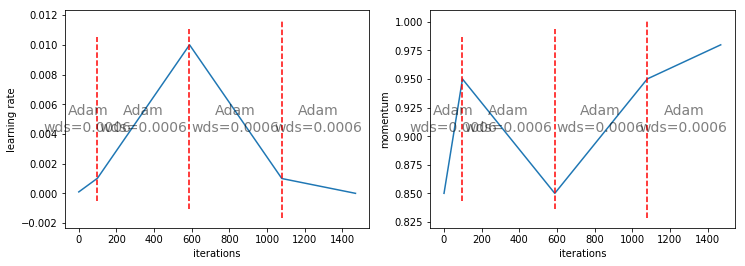

In [14]:
learn.sched.plot_lr()

In [ ]:
learn.load('att6-tta')

In [ ]:
phases = [TrainingPhase(**def_phase, epochs=4, lr=(.04,.001), lr_decay=DecayType.LINEAR, momentum=(0.95))]
learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [ ]:
tta_data = torch_loader(PATH, sz, prefetcher=False)

In [ ]:
learn.data_ = tta_data

In [ ]:
get_TTA_accuracy(learn)

In [ ]:
get_TTA_accuracy_2(learn)